In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt

In [4]:
# Load the data
genotypes = pd.read_csv('tomatoes/Genotypic_data_maf10_min10_291acc.txt', index_col=0)
phenotype = pd.read_csv('tomatoes/phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    genotypes, phenotype['FREAR'], test_size=0.2, random_state=42)

In [6]:
# Function to calculate minor allele frequency
def calculate_maf(df):
    maf = df.apply(lambda x: min(x.mean(), 1 - x.mean()), axis=0)
    return maf

# Function for LD pruning
def ld_pruning(df, threshold=0.5):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # Updated to use bool
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)

In [7]:
# Apply MAF and LD pruning only to the training set
maf = calculate_maf(X_train)
X_train_filtered = X_train.loc[:, maf > 0.05]  # Filter out SNPs with MAF <= 5%
X_train_pruned = ld_pruning(X_train_filtered)

In [8]:
# Impute missing data and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_pruned), columns=X_train_pruned.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_pruned.columns)

# Apply the same imputation and scaling transformations to the test set
X_test_filtered = X_test[X_train_pruned.columns]  # Keep only the columns that survived pruning
X_test_imputed = pd.DataFrame(imputer.transform(X_test_filtered), columns=X_train_pruned.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_train_pruned.columns)

In [9]:
# Elastic Net for feature selection with increased number of iterations
elastic_net_cv = ElasticNetCV(cv=5, random_state=0, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=10000)
elastic_net_cv.fit(X_train_scaled, y_train)

# Check if the model has converged
if not elastic_net_cv.mse_path_.any():
    print("Model has not converged. Consider increasing max_iter or changing the parameters.")

In [10]:
# Filter features based on coefficients
selected_features = X_train_scaled.columns[elastic_net_cv.coef_ != 0]

In [11]:
# Export selected features
pd.Series(selected_features).to_csv('Features_selected/selected_features_elastic_net.csv', index=False)

In [12]:
# Using selected features for modeling
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

In [13]:
X_train_selected.head()

,IIT8604,IIT8613,IIT8662,IIT12528,IIT11292,IIT10796,solcap_snp_sl_15056,solcap_snp_sl_33709,solcap_snp_sl_60078,solcap_snp_sl_33676,...,IIT9778,IIT9322,CL017629.0231,solcap_snp_sl_15641,solcap_snp_sl_36066,IIT9014,solcap_snp_sl_33666,solcap_snp_sl_19031,solcap_snp_sl_19630,solcap_snp_sl_31975
0,-0.529159,-0.3982,-0.687785,-1.015593,-0.586011,-0.569062,-0.359176,1.964422,2.659013,1.971164,...,1.133913,1.177975,-0.662395,-0.842282,-0.359176,-0.341848,2.333531,-0.494288,0.075985,-0.415339
1,-0.529159,-0.3982,-0.687785,1.024386,-0.586011,1.767617,-0.359176,-0.519207,-0.387362,-0.527798,...,0.122114,-0.900278,-0.662395,-0.842282,-0.359176,-0.341848,-0.442773,-0.494288,1.112950,-0.415339
2,-0.529159,-0.3982,1.468513,1.024386,-0.586011,-0.569062,-0.359176,-0.519207,-0.387362,1.971164,...,-0.889685,1.177975,-0.662395,-0.842282,-0.359176,-0.341848,-0.442773,-0.494288,-0.960981,-0.415339
3,-0.529159,-0.3982,-0.687785,1.024386,-0.586011,-0.569062,-0.359176,1.964422,-0.387362,-0.527798,...,-0.889685,1.177975,-0.662395,1.225543,2.845782,-0.341848,2.333531,2.111960,1.112950,2.595871
4,-0.529159,-0.3982,-0.687785,-1.015593,-0.586011,-0.569062,-0.359176,-0.519207,-0.387362,-0.527798,...,-0.889685,-0.900278,-0.662395,-0.842282,-0.359176,-0.341848,-0.442773,-0.494288,0.075985,-0.415339


In [14]:
# Linear regression with cross-validation
regressor = LinearRegression()
cv_scores = cross_val_score(regressor, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
regressor.fit(X_train_selected, y_train)
y_pred = regressor.predict(X_test_selected)

In [15]:
# Calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mean_cv_rmse = np.sqrt(-cv_scores.mean())


In [16]:
print(f'Test RMSE: {rmse}')
print(f'Test R²: {r2}')
print(f'Cross-Validated RMSE: {mean_cv_rmse}')

Test RMSE: 2.617331962928259
Test R²: 0.03247433953953571
Cross-Validated RMSE: 2.688105331143745


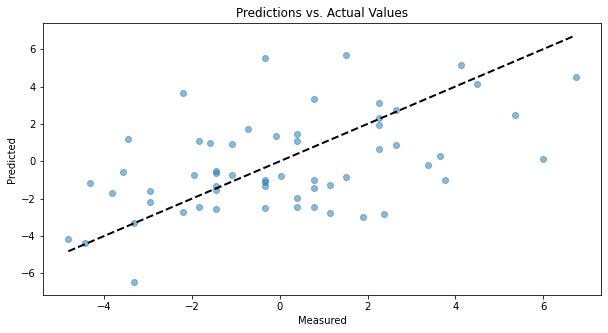

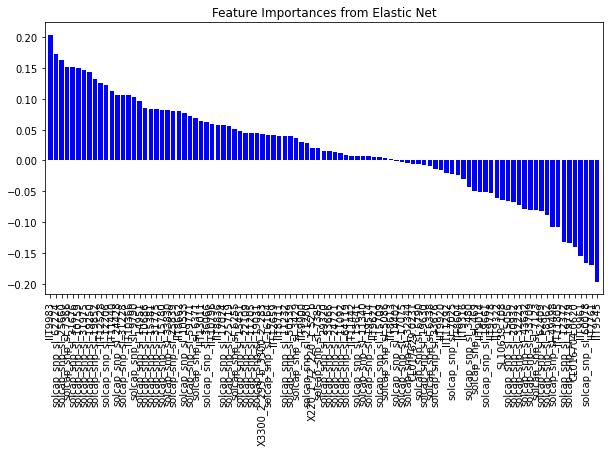

In [17]:
# Visualization of predictions vs. actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predictions vs. Actual Values')
plt.show()

# Visualization of feature importances from Elastic Net
plt.figure(figsize=(10, 5))
importances = elastic_net_cv.coef_[elastic_net_cv.coef_ != 0]
sorted_indices = np.argsort(importances)[::-1]
plt.title('Feature Importances from Elastic Net')
plt.bar(range(len(importances)), importances[sorted_indices], color="b", align="center")
plt.xticks(range(len(importances)), selected_features[sorted_indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()